In [1]:
import sys,os
sys.path.append("../")

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from IPython.display import HTML
from sklearn.metrics import pairwise_distances  


%matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from scipy import stats
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from scipy.stats import entropy
import itertools

import seaborn as sns


from sklearn.metrics import adjusted_mutual_info_score
from sklearn.metrics import pairwise_distances  
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import mutual_info_score
from sklearn.metrics import normalized_mutual_info_score

### Function to take weighted entropy

In [2]:
def weighted_entropy(dataframe, entropy_column, group_columns="cluster", ):
    group_size = dataframe.groupby(group_columns).size()
    group_entropy = dataframe.groupby(group_columns)[entropy_column].apply(lambda x: entropy(x.value_counts().values))
    weighted_entropy = (group_size * group_entropy).mean()
    return weighted_entropy

## reading the change object.

In [3]:
article_name = "John_Logie_Baird"
change_object_dir =  "../data/change objects/"
content_dir = "../data/content/"
filename =  f"{article_name}_change.h5"
change_object_file = os.path.join(change_object_dir, filename)
filename = article_name + ".h5"
filepath = os.path.join(content_dir, filename)
with pd.HDFStore(filepath, 'r') as store:
    token_string_df = store.get("all_tokens")

token_string_df = token_string_df.set_index("token_id")["str"]
token_string_df[-1] = "St@rt"
token_string_df[-2] = "$nd"


if os.path.exists(change_object_file):
    with pd.HDFStore(change_object_file, 'r') as store:
        change_object_dataframe = store.get("data")
else:
    print("file do not exist")
change_object_dataframe.shape


change_object_dataframe["ins_length"] = change_object_dataframe["ins_tokens"].str.len()
change_object_dataframe["del_length"] = change_object_dataframe["del_tokens"].str.len()

change_object_dataframe["del_string_tokens"] = change_object_dataframe["del_tokens"].apply(
    lambda x:  tuple(token_string_df[np.array(x)].tolist()))

change_object_dataframe["ins_string_tokens"] = change_object_dataframe["ins_tokens"].apply(
    lambda x:  tuple(token_string_df[np.array(x)].tolist()))
change_object_dataframe["edit_string_tokens"] = change_object_dataframe["ins_string_tokens"] + change_object_dataframe["del_string_tokens"]



change_object_dataframe["left_context"] = change_object_dataframe["left_token"].apply(
    lambda x:  tuple(token_string_df[np.array(x)].tolist())).str.join(" ")


change_object_dataframe["right_context"] = change_object_dataframe["right_token"].apply(
    lambda x:  tuple(token_string_df[np.array(x)].tolist())).str.join(" ")

change_object_dataframe["bykau_cluster"] = pd.Series(-99,index=change_object_dataframe.index)

# change_object_dataframe = change_object_dataframe[["left_context","del_string_tokens","ins_string_tokens", "right_context", 
#                                                    "ins_length", "del_length", "bykau_cluster" ]]
change_object_dataframe.head()

ins_start_pos  \
from revision id to revision id timestamp           timegap           editor                    
203693           203699         2002-09-08 14:05:32 194 days 22:14:17 3646   0           10.0   
                                                                             1           32.0   
                                                                             2           34.0   
                                                                             3           50.0   
                                                                             4           57.0   

                                                                                ins_end_pos  \
from revision id to revision id timestamp           timegap           editor                  
203693           203699         2002-09-08 14:05:32 194 days 22:14:17 3646   0         30.0   
                                                                             1         32.0   
                                                                             2         34.0   
                                                                             3         55.0   
                                                                             4         73.0   

                                                                                left_neigh  \
from revision id to revision id timestamp           timegap           editor                 
203693           203699         2002-09-08 14:05:32 194 days 22:14:17 3646   0           9   
                                                                             1          10   
                                                                             2          11   
                                                                             3          26   
                                                                             4          32   

                                                                                right_neigh  \
from revision id to revision id timestamp           timegap           editor                  
203693           203699         2002-09-08 14:05:32 194 days 22:14:17 3646   0           10   
                                                                             1           11   
                                                                             2           12   
                                                                             3           32   
                                                                             4           36   

                                                                                del_start_pos  \
from revision id to revision id timestamp           timegap           editor                    
203693           203699         2002-09-08 14:05:32 194 days 22:14:17 3646   0           -1.0   
                                                                             1           -1.0   
                                                                             2           -1.0   
                                                                             3           27.0   
                                                                             4           33.0   

                                                                                del_end_pos  \
from revision id to revision id timestamp           timegap           editor                  
203693           203699         2002-09-08 14:05:32 194 days 22:14:17 3646   0         -1.0   
                                                                             1         -1.0   
                                                                             2         -1.0   
                                                                             3         31.0   
                                                                             4         35.0   

                                                               

In [4]:
change_object_dataframe.shape

(4900, 20)

## Reduce the change object.

In [5]:
ins_and_del = change_object_dataframe[(change_object_dataframe["ins_string_tokens"]!=()) & (change_object_dataframe["del_string_tokens"]!=())]
display(ins_and_del.shape)

(2018, 20)

### Removing change object with insert or delete token size more than five.

In [6]:
reduced_ins_and_del = ins_and_del[~((ins_and_del["ins_length"] >5 ) | (ins_and_del["del_length"] >5) )]
reduced_ins_and_del.shape

(1542, 20)

In [7]:
reduced_ins_and_del.reset_index(drop=True)[["ins_string_tokens", "del_string_tokens"]].sample(3)

,ins_string_tokens,del_string_tokens
41,"(mechanica, [, ooooooooiiiiiiiiiiiiiiiiiiiiiii...","(mechanical,)"
320,"(major,)","(very, small)"
498,"(21, june, 1999)","(13, august, 1888)"


### Removing low user support tokens

In [8]:
bykau_change_object = reduced_ins_and_del.groupby("ins_string_tokens").filter(lambda x : x.index.get_level_values("editor").nunique()>=2)
bykau_change_object = bykau_change_object.groupby("del_string_tokens").filter(lambda x : x.index.get_level_values("editor").nunique()>=2)
bykau_change_object.shape

(493, 20)

#### read annotations

In [9]:
file_name = article_name + "_FULL.csv"
annotation_dir = "../data/annotation/"
full_file_path = os.path.join(annotation_dir, file_name)
annotation_df = pd.read_csv(full_file_path)
annotation_df = annotation_df[["revid_ctxt", "token_id",
                               "rev_id", "nationality", "birth_place","Bulk" ]]
true_labels = np.zeros((annotation_df.shape[0]))
true_labels[(annotation_df["nationality"].str.strip() == "Y").values] = 1
annotation_df["nationality"] = true_labels

## Function for weighted entropy

In [10]:
def weighted_token_entropy(dataframe, group_by):
    cluster_sizes = dataframe.groupby(group_by).size()
    token_entropy_clusters = dataframe.groupby(group_by)["edit_string_tokens"].apply(
                    lambda token_tuples: entropy(pd.Series(
                    [token for token_tuple in token_tuples.tolist() for token in token_tuple]
                    ).value_counts().values))
    cluster_entropy = (cluster_sizes * token_entropy_clusters).sum()
    return cluster_entropy

### Clustering using jaccard

##### Defining jaccard similarity function.

In [11]:
def bykau_distances(dataframe, context = 8):
    left_neighbours = dataframe["left_context"].apply(lambda x: x.split(" ")[-context:])
    right_neighbours = dataframe["right_context"].apply(lambda x: x.split(" ")[:context])
    
    neighbour_tokens = left_neighbours + right_neighbours
    neighbour_tokens_set = neighbour_tokens.apply(lambda x: np.unique(x))
    
    neighbour_vec = MultiLabelBinarizer().fit_transform(neighbour_tokens_set)
    return pairwise_distances(neighbour_vec, metric="jaccard")
#     db = DBSCAN(eps=eps, min_samples=min_samples, metric='jaccard').fit(neighbour_vec)
#     return db.labels_ 

In [12]:
def bykau_cluster(distances, eps=0.75, min_samples=5):
    db = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed').fit(distances)
    return db.labels_ 


In [13]:
def token_in_gap(ann, gap_df, gap_cluster_df):
    context_gap = gap_df.loc[ann[['revid_ctxt', 'rev_id']]]
    context_cluster = gap_cluster_df.loc[ann[['revid_ctxt', 'rev_id']]]
    clusters = context_cluster.loc[ context_gap["token_id"].apply(
            lambda x: ann["token_id"] in x),:].values
    if clusters.size >0:
            clusters = pd.Series(clusters[0],index=gap_cluster_df.columns)
    else:
        clusters = pd.Series(-10, index=gap_cluster_df.columns)
    return clusters

In [14]:
def evaluate_bykau(change_object_dataframe, annotation_df):
    ins_array = change_object_dataframe.reset_index().loc[
    change_object_dataframe["ins_start_pos"].values != -1, 
                  ["to revision id","ins_tokens", 'to revision id', "bykau_cluster"]].values

    # delete array is always done in from revision so taking it and leaving other change object where delete does not come.
    del_array = change_object_dataframe.reset_index().loc[
    change_object_dataframe["del_start_pos"].values != -1, 
                  ["from revision id","del_tokens", 'to revision id',"bykau_cluster"]].values

    gap_array = np.concatenate([ins_array,del_array], axis=0)
    gap_df = pd.DataFrame(gap_array,columns= ["revid_ctxt", "token_id", "rev_id","bykau_cluster"])
    gap_df = gap_df.set_index(['revid_ctxt', 'rev_id'])
    
    annotation_df["bykau_cluster"] = annotation_df.apply(token_in_gap, axis=1, args=(gap_df,))
    nationality_cluster = np.zeros((annotation_df.shape[0]))
    nationality_cluster[annotation_df["nationality"].str.strip() == "Y"] = 1
    annotation_df["nationality_cluster"] = nationality_cluster

    evaluation_score = pd.Series(index=["rand", "entropy",])
    evaluation_score["rand"] = adjusted_rand_score( annotation_df["bykau_cluster"], nationality_cluster)
    evaluation_score["entropy"] = weighted_entropy(annotation_df, group_columns="bykau_cluster", entropy_column="nationality_cluster")
    return evaluation_score   

In [15]:
context_array  = np.array([2, 4, 8, 15, 30])
eps_array =[0.001, 0.025, 0.05, 0.1, 0.2, 0.4, 0.8]

min_samples_array = 2 
all_combinations = list(itertools.product(context_array, eps_array))

idx = pd.MultiIndex.from_product([context_array, eps_array],
                                names=["context","eps"])


all_combinations = list(itertools.product(context_array, eps_array))


bykau_cluster_df =  pd.DataFrame(columns=idx, index= bykau_change_object.index) #pd.DataFrame(columns=idx)

bykau_evaluation_df = pd.DataFrame(index=idx, columns=["rand", "entropy"])


In [16]:
for context in context_array:
    distances = bykau_distances(bykau_change_object, context = context)
    for eps in eps_array:
        clusters = bykau_cluster(distances, eps=eps, min_samples=2)
        
        bykau_cluster_df.loc[bykau_change_object.index, (context,eps)] = pd.Series(clusters, index=bykau_change_object.index)

/home/ubuntu/anaconda3/envs/wrod2vec/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/home/ubuntu/anaconda3/envs/wrod2vec/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/home/ubuntu/anaconda3/envs/wrod2vec/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/home/ubuntu/anaconda3/envs/wrod2vec/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/home/ubuntu/anaconda3/envs/wrod2vec

In [17]:
# insert array is always done in to revision so taking it and leaving other change object where 
ins_array = bykau_change_object.reset_index().loc[
    bykau_change_object["ins_start_pos"].values != -1, 
                  ["to revision id","ins_tokens", 'to revision id']].values
ins_cluster = bykau_cluster_df.loc[
    bykau_change_object["ins_start_pos"].values != -1, :]

# delete array is always done in from revision so taking it and leaving other change object where delete does not come.
del_array = bykau_change_object.reset_index().loc[
    bykau_change_object["del_start_pos"].values != -1, 
                  ["from revision id","del_tokens", 'to revision id']].values
del_cluster = bykau_cluster_df.loc[
    bykau_change_object["del_start_pos"].values != -1, :]

gap_array = np.concatenate([ins_array,del_array], axis=0)
gap_df = pd.DataFrame(gap_array,columns=["revid_ctxt", "token_id",
                               "rev_id"])

gap_cluster= pd.concat([ins_cluster, del_cluster], axis=0)
gap_df = gap_df.set_index(['revid_ctxt', 'rev_id'])
gap_cluster_df = pd.concat([ins_cluster, del_cluster], axis=0)

gap_cluster_df.index=gap_df.index

In [18]:
# Finding the tokens who were in the gap.
al_combination_clusters_df = annotation_df.apply(token_in_gap, axis=1, args=(gap_df, gap_cluster_df))

annotation_clusters = pd.concat([annotation_df, al_combination_clusters_df], axis=1)

annotation_clusters.head()
#true_labels[true_lable_df["birth_place"].str.strip() == "Y"] = 2

,revid_ctxt,token_id,rev_id,nationality,birth_place,Bulk,"(2, 0.001)","(2, 0.025)","(2, 0.05)","(2, 0.1)",...,"(15, 0.2)","(15, 0.4)","(15, 0.8)","(30, 0.001)","(30, 0.025)","(30, 0.05)","(30, 0.1)","(30, 0.2)","(30, 0.4)","(30, 0.8)"
0,26479217,2127,26479217,0.0,Y,N,-10,-10,-10,-10,...,-10,-10,-10,-10,-10,-10,-10,-10,-10,-10
1,26479217,2180,26479217,0.0,Y,N,-10,-10,-10,-10,...,-10,-10,-10,-10,-10,-10,-10,-10,-10,-10
2,34662413,2507,34662413,0.0,Y,Y,-10,-10,-10,-10,...,-10,-10,-10,-10,-10,-10,-10,-10,-10,-10
3,36934652,2127,38966139,0.0,Y,N,-10,-10,-10,-10,...,-10,-10,-10,-10,-10,-10,-10,-10,-10,-10
4,39102207,2574,39102207,0.0,Y,N,-10,-10,-10,-10,...,-10,-10,-10,-10,-10,-10,-10,-10,-10,-10


# Calculating the entropy of the Annotated change objects

In [19]:
df2 = gap_df.copy()
df2=df2.reset_index()
df2['nationality'] = 0

aci = annotation_clusters.set_index(['revid_ctxt', 'rev_id']).sort_index()
aci = aci[aci['Bulk'] =='N']
aci_y=aci[aci['nationality'] == 1]
aci_n=aci[aci['nationality'] == 0]

counter = 0
def nat_val(row):
    global counter
    val = 0
    x=0
    y=0
    try:
        x = int(aci_y.loc[(row[0],row[1]), ['token_id']].isin(row[2]).sum())
        val = val + (1 if x > 0 else 0)
        
    except KeyError as e:
        pass
    try:
        y = int(aci_n.loc[(row[0],row[1]), ['token_id']].isin(row[2]).sum())
        val = val - (1 if y > 0 else 0)
        counter += y
    except KeyError as e:
        pass
#     if (1 if x > 0 else 0) + (1 if y > 0 else 0) > 1:
#         try:
#             if not (aci.loc[(row[0],row[1]),['Bulk']] == 'Y').all()[0]:
#                 print((aci.loc[(row[0],row[1]),['token_id','nationality','Bulk']])[aci.loc[(row[0],row[1]), 'token_id'].isin(row[2])])
#                 print(aci.loc[(row[0],row[1]), ['token_id']].isin(row[2]))
#         except:
#             import pdb; pdb.set_trace()
    return val 
    
df2['nationality'] = df2[['revid_ctxt', 'rev_id', 'token_id']].apply(nat_val, axis=1)
df3 = pd.concat([df2, gap_cluster_df.reset_index()], axis=1)
df3['nationality'].value_counts()

 0    674
 1    269
-1     43
Name: nationality, dtype: int64

In [20]:
entropies = []
print("Without bulks")
for context, eps in all_combinations:
#     print(str((context, eps)) + ": " + str(weighted_entropy(df3, entropy_column="nationality", group_columns=(context, eps))))
#     bykau_evaluation_df["entropy_change"].sort_values().iloc[0:20]
    bykau_evaluation_df.loc[(context, eps),"change_object_entropy"] = weighted_entropy(df3, 
                                                                            entropy_column="nationality", 
                                                                            group_columns=(context, eps))

Without bulks


# Calculating the entropy of the Annotated cases

In [21]:
a = annotation_df.loc[al_combination_clusters_df.mean(axis=1) > -10]
b = al_combination_clusters_df.loc[al_combination_clusters_df.mean(axis=1) > -10]

annotation_clusters = pd.concat([a,b], axis=1)

In [22]:
df4 = annotation_clusters[annotation_clusters['Bulk']=='N']
for context, eps in all_combinations:
    bykau_evaluation_df.loc[(context, eps),"row_based_entropy"] = weighted_entropy(df4, 
                                                                                entropy_column="nationality", 
                                                                                group_columns=(context, eps))
    bykau_evaluation_df.loc[(context, eps),"rand"] = adjusted_rand_score(df4[(context, 
                                                                                                      eps)], 
                                                                                 df4["nationality"])

bykau_evaluation_df.head(10)
#bykau_evaluation_df["entropy"].sort_values().iloc[0:20]

rand entropy  change_object_entropy  row_based_entropy
context eps                                                               
2       0.001  0.0352561     NaN               1.606768           0.988827
        0.025  0.0352561     NaN               1.606768           0.988827
        0.050  0.0352561     NaN               1.606768           0.988827
        0.100  0.0352561     NaN               1.606768           0.988827
        0.200  0.0352561     NaN               1.606768           0.988827
        0.400   0.113457     NaN               2.304085           5.002615
        0.800 -0.0484911     NaN              28.111225          43.768974
4       0.001  0.0203247     NaN               1.879041           1.089537
        0.025  0.0203247     NaN               1.879041           1.089537
        0.050  0.0203247     NaN               1.879041           1.089537

In [33]:
bykau_evaluation_df

rand entropy  change_object_entropy  row_based_entropy  \
context eps                                                                  
2       0.001  0.0352561     NaN               1.606768           0.988827   
        0.025  0.0352561     NaN               1.606768           0.988827   
        0.050  0.0352561     NaN               1.606768           0.988827   
        0.100  0.0352561     NaN               1.606768           0.988827   
        0.200  0.0352561     NaN               1.606768           0.988827   
        0.400   0.113457     NaN               2.304085           5.002615   
        0.800 -0.0484911     NaN              28.111225          43.768974   
4       0.001  0.0203247     NaN               1.879041           1.089537   
        0.025  0.0203247     NaN               1.879041           1.089537   
        0.050  0.0203247     NaN               1.879041           1.089537   
        0.100  0.0203247     NaN               1.879041           1.089537   
        0.200  0.0200395     NaN               1.755628           1.122052   
        0.400   0.137021     NaN               1.630278           1.593958   
        0.800  0.0463284     NaN              47.158295          44.910451   
8       0.001  0.0230147     NaN               2.291778           1.161137   
        0.025  0.0230147     NaN               2.291778           1.161137   
        0.050  0.0230147     NaN               2.291778           1.161137   
        0.100  0.0272549     NaN               2.228513           1.067319   
        0.200  0.0282073     NaN               1.488581           1.034968   
        0.400  0.0307952     NaN               2.125935           3.152665   
        0.800          0     NaN              80.278099         137.022062   
15      0.001  0.0189343     NaN               2.897417           1.184852   
        0.025  0.0189343     NaN               2.897417           1.184852   
        0.050  0.0201232     NaN               2.908407           1.324575   
        0.100  0.0100892     NaN               1.878670           1.077431   
        0.200  0.0313547     NaN               1.379844           0.931273   
        0.400   0.047073     NaN               3.216836           2.962528   
        0.800   0.217389     NaN             118.144326          40.321683   
30      0.001  0.0246737     NaN               3.534884           1.237561   
        0.025  0.0180781     NaN               3.319610           1.233041   
        0.050  0.0125126     NaN               2.333773           1.166586   
        0.100  0.0294394     NaN               1.488936           0.933739   
        0.200  0.0202607     NaN               2.585026           2.201318   
        0.400  0.0321993     NaN               5.450649           3.832088   
        0.800          0     NaN             146.406798         137.022062   

               token_entropy  
context eps                   
2       0.001     728.857679  
        0.025     728.857679  
        0.050     728.857679  
        0.100     728.857679  
        0.200     728.857679  
        0.400     727.498275  
        0.800    1524.910947  
4       0.001     819.249199  
        0.025     819.249199  
        0.050     819.249199  
        0.100     819.249199  
        0.200     795.249240  
        0.400     726.119392  
        0.800    1663.899251  
8       0.001     898.301664  
        0.025     898.301664  
        0.050     898.301664  
        0.100     890.272178  
        0.200     766.137690  
        0.400     776.350068  
        0.800    1729.895741  
15      0.001    1020.890970  
        0.025    1020.890970  
        0.050     997.160193  
        0.100     851.899956  
        0.200     762.520407  
        0.400     862.733933  
        0.800    1736.991407  
30      0.001    1122.025695  
        0.025    1087.908204  
        0.050     963.921297  
        0.100     852.940872  
        0.200     843.963374  
        0.400     951.650429  
        0.800    

### **@Aadil**, the rankindex here is wrong because all the nationality clusters hould be mark as one


In [23]:
def weighted_token_entropy(dataframe, group_by):
    cluster_sizes = dataframe.groupby(group_by).size()
    token_entropy_clusters = dataframe.groupby(group_by)["edit_string_tokens"].apply(
                    lambda token_tuples: entropy(pd.Series(
                    [token for token_tuple in token_tuples.tolist() for token in token_tuple]
                    ).value_counts().values))
    cluster_entropy = (cluster_sizes * token_entropy_clusters).sum()
    return cluster_entropy

In [24]:
#bykau_cluster_df.index = change_object_dataframe.index
bykau_cluster_df.index = bykau_change_object.index


bykau_optimised = pd.concat([change_object_dataframe, bykau_cluster_df], axis=1)

In [25]:
entropy_series_with_optimization = pd.Series(index=all_combinations)

for context_eps_tuple in all_combinations:
    bykau_evaluation_df.loc[context_eps_tuple,
                                              "token_entropy"] = weighted_token_entropy(bykau_optimised, 
                                                                                        context_eps_tuple)

In [26]:
bykau_evaluation_df.astype(np.float64).corr()

,rand,entropy,change_object_entropy,row_based_entropy,token_entropy
rand,1.000000,NaN,0.246036,-0.094027,0.040811
entropy,NaN,NaN,NaN,NaN,NaN
change_object_entropy,0.246036,NaN,1.000000,0.873066,0.863896
row_based_entropy,-0.094027,NaN,0.873066,1.000000,0.826465
token_entropy,0.040811,NaN,0.863896,0.826465,1.000000


(0.0, 1.0, 0.0, 1.0)

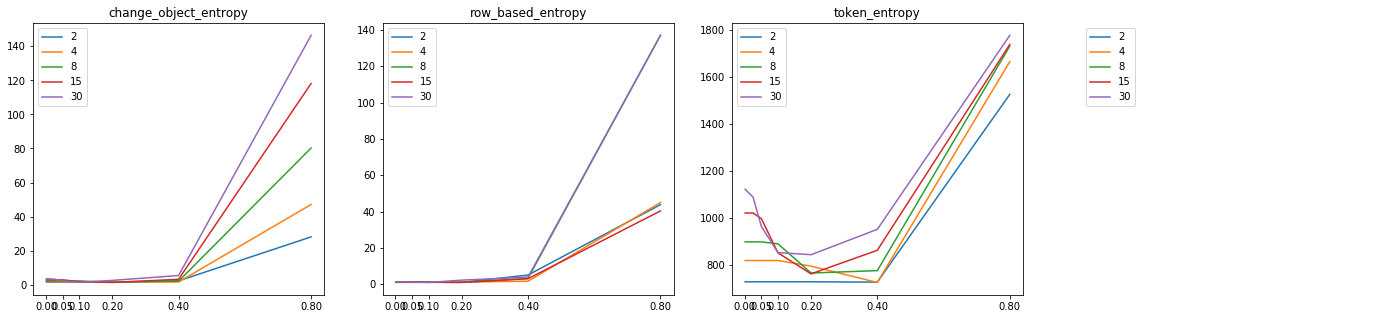

In [37]:
_df = bykau_evaluation_df.reset_index()

cols = [
    'change_object_entropy', 'row_based_entropy', 'token_entropy',
]

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(24,5))
for i, column in enumerate(cols):
    _ax = axes[i]
    _ax.xaxis.label.set_visible(False)
    
    for name2, subdf2 in _df.groupby(['context']): 
        subdf2.plot(x = 'eps', y=column, ax=_ax, label=str(name2), title=column,  xticks=[0,.05,.1,.2,.4,.8])

handles, labels = _ax.get_legend_handles_labels()
axes[3].legend(handles, labels, loc='upper left')
axes[3].axis('off')
